In [1]:
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim

torch.set_printoptions(edgeitems=2)

In [2]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # <1>
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

t_u.shape

torch.Size([11, 1])

In [3]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 3,  6,  2,  5,  8,  0, 10,  9,  4]), tensor([7, 1]))

In [4]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [5]:
import torch.nn as nn

linear_model = nn.Linear(1, 1) # <1>
linear_model(t_un_val)

tensor([[-0.9852],
        [-2.6876]], grad_fn=<AddmmBackward>)

In [6]:
linear_model.weight

Parameter containing:
tensor([[-0.4992]], requires_grad=True)

In [7]:
linear_model.bias

Parameter containing:
tensor([0.1031], requires_grad=True)

In [8]:
x = torch.ones(1)
linear_model(x)

tensor([-0.3961], grad_fn=<AddBackward0>)

In [9]:
x = torch.ones(10, 1)
linear_model(x)

tensor([[-0.3961],
        [-0.3961],
        [-0.3961],
        [-0.3961],
        [-0.3961],
        [-0.3961],
        [-0.3961],
        [-0.3961],
        [-0.3961],
        [-0.3961]], grad_fn=<AddmmBackward>)

In [10]:
linear_model = nn.Linear(1, 1) # <1>
optimizer = optim.SGD(
    linear_model.parameters(), # <2>
    lr=1e-2)

In [11]:
linear_model.parameters()

<generator object Module.parameters at 0x0000020A2B022D58>

In [12]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[0.3791]], requires_grad=True), Parameter containing:
 tensor([-0.5349], requires_grad=True)]

In [13]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train) # <1>
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val) # <1>
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward() # <2>
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print('Epoch {}, Training loss {}, Validation loss {}'.format(
                epoch, float(loss_train), float(loss_val)))


In [14]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

linear_model = nn.Linear(1, 1) # <1>
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = loss_fn,
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 82.00872802734375, Validation loss 55.06585693359375
Epoch 1000, Training loss 4.997957229614258, Validation loss 1.2232692241668701
Epoch 2000, Training loss 3.021897077560425, Validation loss 2.7614946365356445
Epoch 3000, Training loss 2.8582355976104736, Validation loss 4.448704719543457

Parameter containing:
tensor([[5.5630]], requires_grad=True)
Parameter containing:
tensor([-18.6652], requires_grad=True)


In [15]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(), # <1>
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 92.3511962890625, Validation loss 57.714385986328125
Epoch 1000, Training loss 4.910993576049805, Validation loss 1.173926591873169
Epoch 2000, Training loss 3.014694929122925, Validation loss 2.8020541667938232
Epoch 3000, Training loss 2.857640504837036, Validation loss 4.464878559112549

Parameter containing:
tensor([[5.5647]], requires_grad=True)
Parameter containing:
tensor([-18.6750], requires_grad=True)


In [16]:
seq_model = nn.Sequential(
            nn.Linear(1, 13), # <1>
            nn.Tanh(),
            nn.Linear(13, 1)) # <2>
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [17]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [18]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [19]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8, 1))
]))

seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [20]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [21]:
seq_model.output_linear.bias

Parameter containing:
tensor([-0.2194], requires_grad=True)

In [22]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3) # <1>

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)
    
print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 207.2268524169922, Validation loss 106.6062240600586
Epoch 1000, Training loss 6.121204376220703, Validation loss 2.213937759399414
Epoch 2000, Training loss 5.273784637451172, Validation loss 0.0025627268478274345
Epoch 3000, Training loss 2.4436306953430176, Validation loss 1.9463319778442383
Epoch 4000, Training loss 1.6909029483795166, Validation loss 4.027190685272217
Epoch 5000, Training loss 1.4900192022323608, Validation loss 5.368413925170898
output tensor([[-1.8966],
        [11.1774]], grad_fn=<AddmmBackward>)
answer tensor([[-4.],
        [14.]])
hidden tensor([[-0.0073],
        [ 4.0584],
        [-4.5080],
        [-4.4498],
        [ 0.0127],
        [-0.0073],
        [-4.1530],
        [-0.6572]])


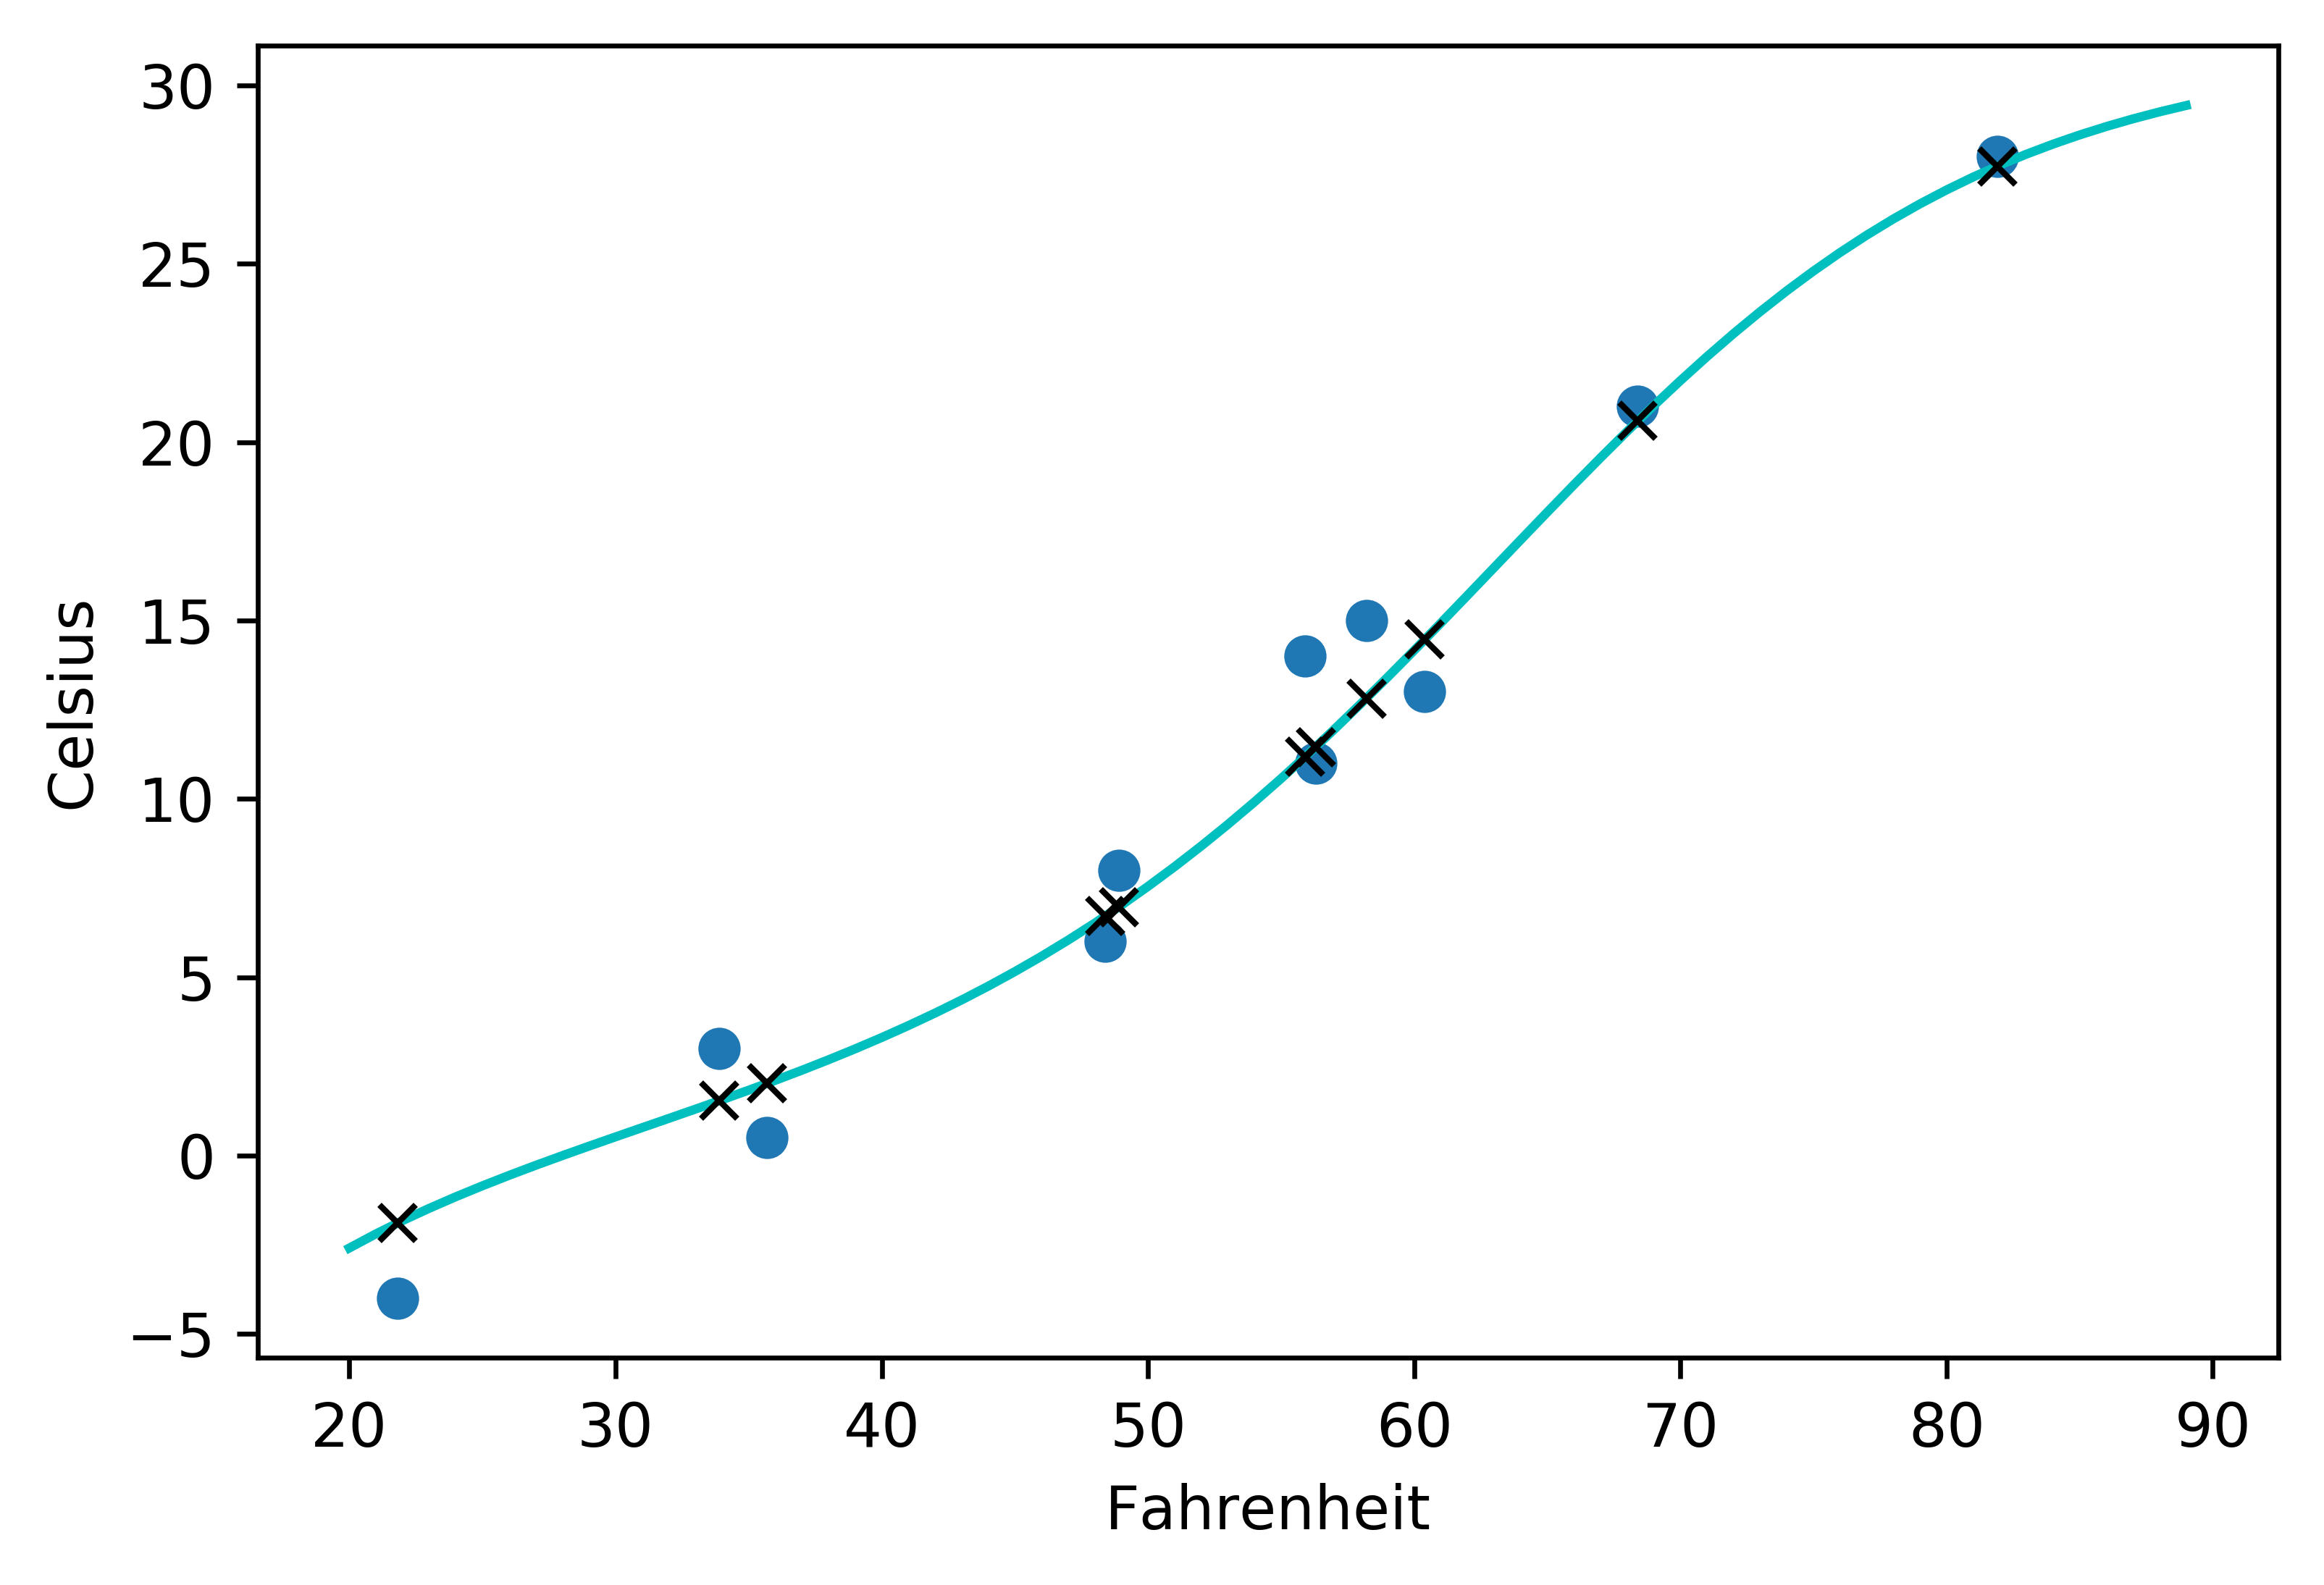

In [23]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')


Epoch 1, Training loss 203.22389221191406, Validation loss 104.12740325927734
Epoch 1000, Training loss 49.626617431640625, Validation loss 56.38867950439453
Epoch 2000, Training loss 35.23250198364258, Validation loss 37.46330642700195
Epoch 3000, Training loss 23.670225143432617, Validation loss 19.621896743774414
Epoch 4000, Training loss 15.505778312683105, Validation loss 8.775274276733398
Epoch 5000, Training loss 10.130289077758789, Validation loss 3.130990743637085


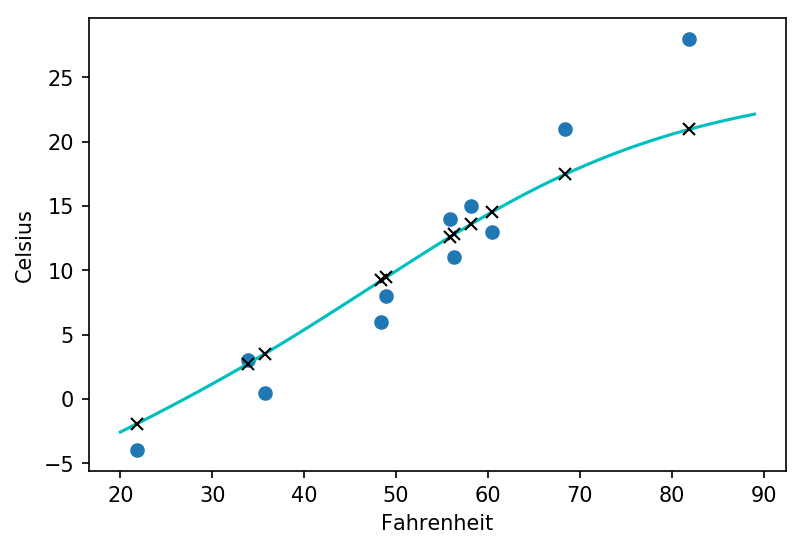

In [24]:
# Exercises here!

neuron_count = 20

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, neuron_count)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(neuron_count, 1))
]))

optimizer = optim.SGD(seq_model.parameters(), lr=1e-4)

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=150)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')
